## Importando a biblioteca yfinance para obter dados financeiros de ações

In [1]:
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

## Coleta dos dados, da ação ITUB4 (Itaú Unibanco) dos últimos 5 anos

In [2]:
itau = yf.Ticker("ITUB4.SA")

In [3]:
print("Informações do Itau:")
print(itau.info)

Informações do Itau:
{'address1': 'PraCa Alfredo Egydio de Souza Aranha', 'address2': 'n 100,Torre Olavo Setubal Parque Jabaquara', 'city': 'São Paulo', 'state': 'SP', 'zip': '04344-902', 'country': 'Brazil', 'phone': '55 11 2794 3547', 'website': 'https://www.itau.com.br', 'industry': 'Banks - Regional', 'industryKey': 'banks-regional', 'industryDisp': 'Banks - Regional', 'sector': 'Financial Services', 'sectorKey': 'financial-services', 'sectorDisp': 'Financial Services', 'longBusinessSummary': 'Itaú Unibanco Holding S.A. provides various financial products and services to personal and corporate customers in Brazil and internationally. It operates through three segments: Retail Business, Wholesale Business and Activities with the Market + Corporation. The company offers current accounts; funds management; payments and collections; loans; credit and debit cards; investment and commercial banking services; real estate lending and financing services; economic, financial and brokerage ad

In [4]:
itau_history = itau.history(period="5y")

In [5]:
print("\nHistórico de preços do Itau:")
print(itau_history.head())


Histórico de preços do Itau:
                                Open       High        Low      Close  \
Date                                                                    
2021-02-18 00:00:00-03:00  17.954199  18.327173  17.883462  17.947767   
2021-02-19 00:00:00-03:00  17.934911  18.134260  17.581229  17.761286   
2021-02-22 00:00:00-03:00  17.073213  17.111797  16.417293  16.468739   
2021-02-23 00:00:00-03:00  16.661658  17.639107  16.623074  17.523357   
2021-02-24 00:00:00-03:00  17.639109  17.696984  17.111801  17.266136   

                             Volume  Dividends  Stock Splits  
Date                                                          
2021-02-18 00:00:00-03:00  55882732        0.0           0.0  
2021-02-19 00:00:00-03:00  30505118        0.0           0.0  
2021-02-22 00:00:00-03:00  97990677        0.0           0.0  
2021-02-23 00:00:00-03:00  86633938        0.0           0.0  
2021-02-24 00:00:00-03:00  40386578        0.0           0.0  


In [6]:
df = pd.DataFrame({
    "ticker": "ITUB4",
    "date": itau_history.index,
    "open": itau_history["Open"],
    "high": itau_history["High"],
    "low": itau_history["Low"],
    "close": itau_history["Close"],
    "volume": itau_history["Volume"],
    "dividend": itau_history["Dividends"],
    "stock_splits": itau_history["Stock Splits"]
}).reset_index(drop=True)

In [7]:
df.head(15)

,ticker,date,open,high,low,close,volume,dividend,stock_splits
0,ITUB4,2021-02-18 00:00:00-03:00,17.954199,18.327173,17.883462,17.947767,55882732,0.000000,0.0
1,ITUB4,2021-02-19 00:00:00-03:00,17.934911,18.134260,17.581229,17.761286,30505118,0.000000,0.0
2,ITUB4,2021-02-22 00:00:00-03:00,17.073213,17.111797,16.417293,16.468739,97990677,0.000000,0.0
3,ITUB4,2021-02-23 00:00:00-03:00,16.661658,17.639107,16.623074,17.523357,86633938,0.000000,0.0
4,ITUB4,2021-02-24 00:00:00-03:00,17.639109,17.696984,17.111801,17.266136,40386578,0.000000,0.0
5,ITUB4,2021-02-25 00:00:00-03:00,17.298273,17.401163,16.706659,16.725950,46423088,0.000000,0.0
6,ITUB4,2021-02-26 00:00:00-03:00,16.943897,17.066772,16.497664,16.523533,54721294,0.129733,0.0
7,ITUB4,2021-03-01 00:00:00-03:00,16.759727,16.805024,16.028511,16.028511,51129457,0.013239,0.0
8,ITUB4,2021-03-02 00:00:00-03:00,15.743782,17.031498,15.478473,16.675596,75324899,0.000000,0.0
9,ITUB4,2021-03-03 00:00:00-03:00,16.675603,17.012091,16.060864,16.714428,69736603,0.000000,0.0


In [8]:
df.tail(15)

,ticker,date,open,high,low,close,volume,dividend,stock_splits
1233,ITUB4,2026-01-27 00:00:00-03:00,44.762106,46.051592,44.672142,45.301891,40280000,0.000000,0.0
1234,ITUB4,2026-01-28 00:00:00-03:00,45.621763,46.401450,45.611768,46.321484,36337500,0.000000,0.0
1235,ITUB4,2026-01-29 00:00:00-03:00,46.661348,47.031199,45.631761,46.131561,36252700,0.000000,0.0
1236,ITUB4,2026-01-30 00:00:00-03:00,46.071584,46.361469,44.962026,45.481819,38117000,0.000000,0.0
1237,ITUB4,2026-02-02 00:00:00-03:00,45.790001,46.099998,45.430000,45.880001,28095400,0.018182,0.0
1238,ITUB4,2026-02-03 00:00:00-03:00,46.299999,46.980000,45.889999,46.139999,48570600,0.000000,0.0
1239,ITUB4,2026-02-04 00:00:00-03:00,45.900002,45.980000,44.049999,44.619999,48683500,0.000000,0.0
1240,ITUB4,2026-02-05 00:00:00-03:00,45.240002,45.880001,44.740002,45.520000,36014400,0.000000,0.0
1241,ITUB4,2026-02-06 00:00:00-03:00,45.590000,46.939999,45.110001,46.750000,38175900,0.000000,0.0
1242,ITUB4,2026-02-09 00:00:00-03:00,47.000000,48.400002,46.740002,48.310001,41656900,0.000000,0.0


In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   ticker        1248 non-null   str                             
 1   date          1248 non-null   datetime64[s, America/Sao_Paulo]
 2   open          1248 non-null   float64                         
 3   high          1248 non-null   float64                         
 4   low           1248 non-null   float64                         
 5   close         1248 non-null   float64                         
 6   volume        1248 non-null   int64                           
 7   dividend      1248 non-null   float64                         
 8   stock_splits  1248 non-null   float64                         
dtypes: datetime64[s, America/Sao_Paulo](1), float64(6), int64(1), str(1)
memory usage: 87.9 KB


In [10]:
total_dividends = df["dividend"].sum()
initial_price = float(df["open"].iloc[0])
final_price = float(df["open"].iloc[-1])
price_change = final_price - initial_price
change_percentage = (price_change / initial_price) * 100

## Análise exploratória dos dados

In [11]:
# Resumo Estatístico
print("=" * 55)
print(f"Ativo: ITUB4 (Itaú Unibanco) | Período: 5 anos")
print("=" * 55)
print(f"Preço inicial (abertura): R$ {initial_price:.2f}")
print(f"Preço final (abertura): R$ {final_price:.2f}")
print(f"Variação total: R$ {price_change:.2f} ({change_percentage:.1f}%)")
print(f"Total dividendos pagos: R$ {df['dividend'].sum():.4f}")
print("=" * 55)
print("\nEstatísticas descritivas do preço de fechamento:")
print(df["close"].describe().round(4).to_string())
print("=" * 55)

Ativo: ITUB4 (Itaú Unibanco) | Período: 5 anos
Preço inicial (abertura): R$ 17.95
Preço final (abertura): R$ 48.07
Variação total: R$ 30.12 (167.7%)
Total dividendos pagos: R$ 9.3529

Estatísticas descritivas do preço de fechamento:
count    1248.0000
mean       23.1155
std         6.9905
min        13.9143
25%        17.7824
50%        20.1664
75%        26.6404
max        49.3700


## 📊 Evolução do preço da ação ITUB4 nos últimos 5 anos

O gráfico abaixo reúne três visões diferentes sobre o comportamento da ação ao longo dos últimos 5 anos.

O primeiro painel mostra o preço de fechamento junto com linhas de tendência. Elas suavizam o sobe e desce do dia a dia e ajudam a enxergar se a ação está em alta ou em baixa no curto, médio e longo prazo.

O segundo painel mostra as Bandas de Bollinger, que são uma faixa de variação esperada para o preço. Quando o preço se aproxima da borda de cima, pode indicar que a ação está cara. Quando vai para a borda de baixo, pode estar barata. Quanto mais larga a faixa, mais agitado está o mercado.

O terceiro painel mostra o volume, ou seja, quantas ações foram negociadas em cada dia. Dias com volume muito alto geralmente coincidem com alguma notícia importante.

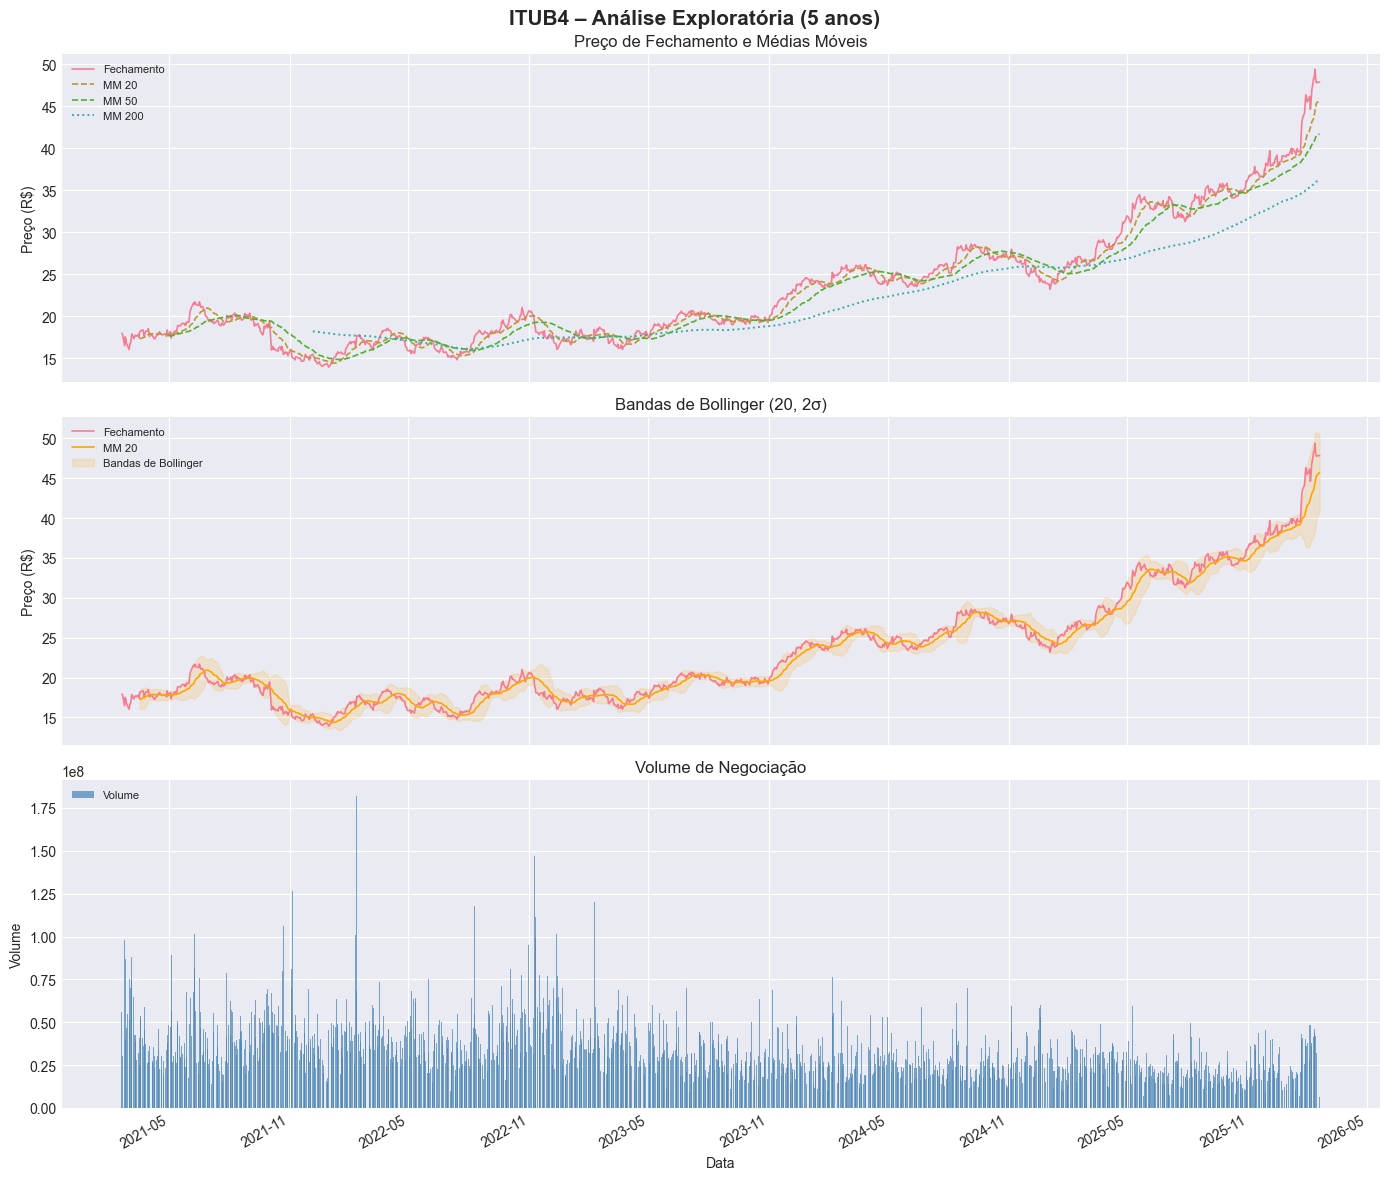

In [12]:
# Evolução do Preço de Fechamento
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle("ITUB4 – Análise Exploratória (5 anos)", fontsize=15, fontweight="bold")

dates = pd.to_datetime(df["date"])

# Painel 1: Preço com médias móveis
ma20  = df["close"].rolling(20).mean()
ma50  = df["close"].rolling(50).mean()
ma200 = df["close"].rolling(200).mean()
axes[0].plot(dates, df["close"], label="Fechamento", linewidth=1.2, alpha=0.9)
axes[0].plot(dates, ma20,  label="MM 20",  linewidth=1.2, linestyle="--")
axes[0].plot(dates, ma50,  label="MM 50",  linewidth=1.2, linestyle="--")
axes[0].plot(dates, ma200, label="MM 200", linewidth=1.4, linestyle=":")
axes[0].set_ylabel("Preço (R$)")
axes[0].legend(loc="upper left", fontsize=8)
axes[0].set_title("Preço de Fechamento e Médias Móveis")

# Painel 2: Bandas de Bollinger
roll_std = df["close"].rolling(20).std()
bb_upper = ma20 + 2 * roll_std
bb_lower = ma20 - 2 * roll_std
axes[1].plot(dates, df["close"], label="Fechamento", linewidth=1.2, alpha=0.9)
axes[1].plot(dates, ma20,      label="MM 20",       linewidth=1.2, color="orange")
axes[1].fill_between(dates, bb_upper, bb_lower, alpha=0.15, color="orange", label="Bandas de Bollinger")
axes[1].set_ylabel("Preço (R$)")
axes[1].legend(loc="upper left", fontsize=8)
axes[1].set_title("Bandas de Bollinger (20, 2σ)")

# Painel 3: Volume
axes[2].bar(dates, df["volume"], width=1.5, alpha=0.7, color="steelblue", label="Volume")
axes[2].set_ylabel("Volume")
axes[2].set_xlabel("Data")
axes[2].legend(loc="upper left", fontsize=8)
axes[2].set_title("Volume de Negociação")
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


## 📉 Variação diária do preço da ação ITUB4

Os dois gráficos abaixo mostram quanto o preço da ação variou de um dia para o outro ao longo dos últimos 5 anos.

O primeiro mostra o sobe e desce diário em forma de linha. A linha vermelha no meio representa o zero, ou seja, nenhuma variação. Pontos acima subiram, pontos abaixo caíram. Picos muito altos ou muito baixos indicam dias de grande agitação no mercado.

O segundo mostra com que frequência cada tamanho de variação aconteceu. A maioria fica perto do zero, o que significa que a ação não costuma variar muito em um único dia. Quanto mais espalhado o gráfico, mais instável a ação.

No final são exibidos 3 números: a **volatilidade anualizada** resume o quanto o preço pode oscilar em um ano inteiro, o **Skewness** diz se as quedas ou as altas costumam ser mais bruscas, e a **Kurtosis** indica com que frequência acontecem variações muito extremas.

[DOC REF](https://medium.com/@diepoemas/compreendendo-de-forma-geral-o-que-representa-skewness-e-kurtosis-na-distribui%C3%A7%C3%A3o-de-seus-dados-a283e8994ce2)

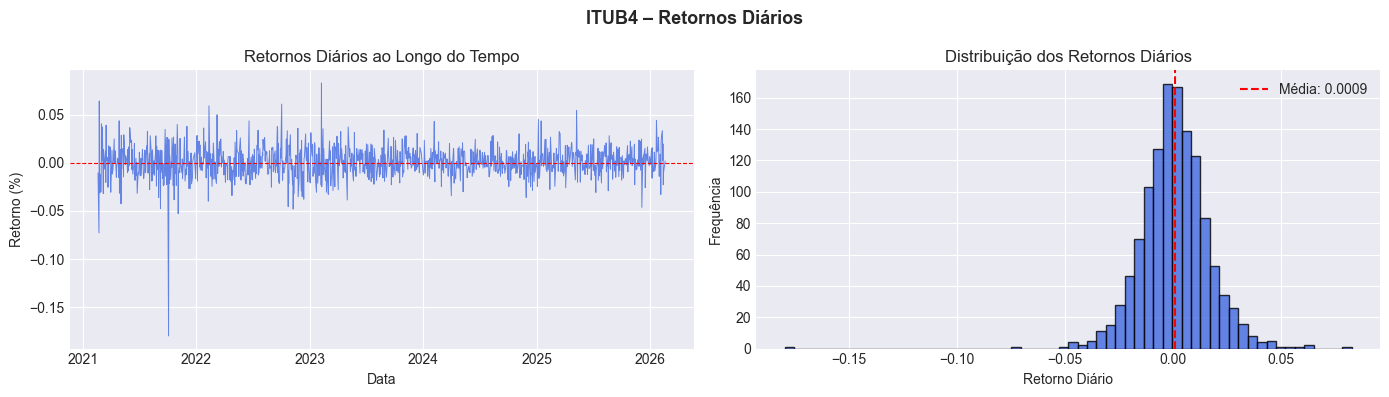


Volatilidade anualizada: 25.38%
Skewness : -0.9731
Kurtosis : 14.0341


In [13]:
# Distribuição de Retornos Diários
df["daily_return"] = df["close"].pct_change()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("ITUB4 – Retornos Diários", fontsize=13, fontweight="bold")

axes[0].plot(dates, df["daily_return"], linewidth=0.7, alpha=0.8, color="royalblue")
axes[0].axhline(0, color="red", linewidth=0.8, linestyle="--")
axes[0].set_title("Retornos Diários ao Longo do Tempo")
axes[0].set_ylabel("Retorno (%)")
axes[0].set_xlabel("Data")

axes[1].hist(df["daily_return"].dropna(), bins=60, edgecolor="black", color="royalblue", alpha=0.8)
axes[1].axvline(df["daily_return"].mean(), color="red", linestyle="--", label=f'Média: {df["daily_return"].mean():.4f}')
axes[1].set_title("Distribuição dos Retornos Diários")
axes[1].set_xlabel("Retorno Diário")
axes[1].set_ylabel("Frequência")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nVolatilidade anualizada: {df['daily_return'].std() * np.sqrt(252) * 100:.2f}%")
print(f"Skewness : {df['daily_return'].skew():.4f}")
print(f"Kurtosis : {df['daily_return'].kurtosis():.4f}")


## 🧠 Desenvolvimento do Modelo LSTM

**LSTM** *(Long Short-Term Memory)* é um tipo de rede neural feita para trabalhar com dados em sequência, neste caso com o preço de uma ação dia após dia. A principal vantagem dela é conseguir "lembrar" de informações do passado para fazer previsões melhores.

O modelo foi construído com 3 camadas empilhadas, onde cada uma aprende padrões mais complexos que a anterior. Entre as camadas há um **Dropout**, que desliga aleatoriamente alguns neurônios durante o treino para evitar que o modelo simplesmente decore os dados em vez de aprender com eles.

O treinamento é controlado por 3 recursos automáticos: o **EarlyStopping** para quando o modelo para de melhorar, o **ModelCheckpoint** salva a melhor versão encontrada e o **ReduceLROnPlateau** reduz a velocidade de aprendizado quando o modelo trava.

In [14]:
# 1. Preparação dos dados
SEQ_LENGTH = 60  # janela de 60 dias de histórico

prices = df["close"].values.reshape(-1, 1)
print("\n Esse é o array de preços original (fechamento):")
print(prices)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)
print("\n Esse é o array de preços normalizados (entre 0 e 1):")
print(scaled_prices)

# Persistir o scaler para uso na API
joblib.dump(scaler, "scaler.pkl")
print("\nScaler salvo em scaler.pkl")


 Esse é o array de preços original (fechamento):
[[17.94776726]
 [17.76128578]
 [16.46873856]
 ...
 [48.24000168]
 [47.77000046]
 [47.86000061]]

 Esse é o array de preços normalizados (entre 0 e 1):
[[0.11376021]
 [0.10850065]
 [0.07204535]
 ...
 [0.9681293 ]
 [0.95487328]
 [0.95741166]]

Scaler salvo em scaler.pkl


In [15]:
# 2. Criação das sequências temporais
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_prices, SEQ_LENGTH)

train_size  = int(len(X) * 0.80)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f"Amostras de treino: {len(X_train)}")
print(f"Amostras de validação: {len(X_val)}")

Amostras de treino: 950
Amostras de validação: 238


### 🏗️ Construção do Modelo LSTM

Aqui o modelo é montado camada por camada. São 3 camadas LSTM empilhadas: a primeira aprende padrões simples, a segunda refina, e a terceira entrega o resultado para a camada final que prevê o próximo preço.

Entre cada camada há um **Dropout de 20%**, que desliga aleatoriamente alguns neurônios durante o treino para evitar que o modelo decore os dados em vez de aprender com eles.

No final, `model.summary()` exibe um resumo da arquitetura: quantidade de camadas, tamanho de cada uma e total de parâmetros que o modelo vai ajustar durante o treino.

| Camada | O que faz | Parâmetros |
|--------|-----------|------------|
| LSTM (128) | Aprende os padrões iniciais nos 60 dias de histórico | 66.560 |
| LSTM (64) | Refina os padrões aprendidos pela camada anterior | 49.408 |
| LSTM (32) | Extrai o resumo final da sequência | 12.416 |
| Dense (16) | Combina as informações para gerar a previsão | 528 |
| Dense (1) | Retorna o preço previsto para o próximo dia | 17 |

No total, o modelo possui **128.929 parâmetros** — ou seja, são quase 130 mil valores que ele vai ajustando durante o treino para aprender a prever o preço da ação.

In [16]:
# 3. Construção do modelo LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1),
])
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

### 🏋️ Treinamento do Modelo

Treinamento do modelo com os dados históricos da ação. Ela roda até 100 vezes pelos dados e, a cada rodada, tenta errar menos na previsão do preço.

Três assistentes automáticos controlam o processo:

- **EarlyStopping**: para o treino se o modelo parar de melhorar por 10 rodadas seguidas;
- **ModelCheckpoint**: salva automaticamente a melhor versão do modelo em `lstm_stock_model.h5`;
- **ReduceLROnPlateau**: reduz a velocidade de aprendizado quando o modelo trava por 5 rodadas seguidas;

Ao final, o histórico do treino fica salvo em `history` para ser usado nos gráficos de avaliação.

In [17]:
# 4. Treinamento com callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("lstm_stock_model.h5", monitor="val_loss", save_best_only=True, verbose=0),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1,
)
print("\nTreinamento concluído. Modelo salvo em lstm_stock_model.h5")

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0161 - mae: 0.0944

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0075 - mae: 0.0615 - val_loss: 0.0018 - val_mae: 0.0325 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 0.0023 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0012 - mae: 0.0269

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0016 - val_mae: 0.0315 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0011 - mae: 0.0258 - val_loss: 0.0016 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 8.5860e-04 - mae: 0.0229 - val_loss: 0.0048 - val_mae: 0.0562 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 8.0714e-04 - mae: 0.0222 - val_loss: 0.0044 - val_mae: 0.0533 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 7.9913e-04 - mae: 0.0218 - val_loss: 0.0062 - val_mae: 0.0675 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8.7162e-04 - mae: 0.0228
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.7599e-04 - mae: 0.0229 - val_loss: 0.0026 - val_mae: 0.0374 - learning_rate: 0.

## 📏 Avaliação do Modelo

Depois de treinar o modelo, colocamos ele à prova com dados que ele nunca tinha visto. O resultado vem em 3 números que mostram o quanto ele errou.

**MAE** é o erro médio em reais. Se der R$ 0,50, quer dizer que o modelo errou 50 centavos por dia, em média. Simples assim.

**RMSE** é parecido com o MAE, mas reage mais forte quando o modelo erra feio em algum dia específico. Se o RMSE for bem maior que o MAE, é sinal de que teve alguns dias de erro grande.

**MAPE** é o erro em porcentagem. É o mais fácil de entender — se der 2%, o modelo errou 2% do preço real. Abaixo de 5% é ótimo, entre 5% e 10% ainda é bom, acima de 10% precisa melhorar.

> ⚠️ Nenhum modelo consegue prever o mercado com 100% de acerto. Esses números mostram apenas como ele se saiu com dados do passado.

In [18]:
# 5. Avaliação
y_pred_scaled = model.predict(X_val, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_val_inv = scaler.inverse_transform(y_val)

mae  = mean_absolute_error(y_val_inv, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred))
mape = mean_absolute_percentage_error(y_val_inv, y_pred)

print(f"\n{'='*45}")
print(f"Métricas de Avaliação – Modelo LSTM")
print(f"{'='*45}")
print(f"MAE: R$ {mae:.4f}")
print(f"RMSE: R$ {rmse:.4f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"{'='*45}")


Métricas de Avaliação – Modelo LSTM
MAE: R$ 1.1161
RMSE: R$ 1.4055
MAPE: 3.17%


## 📈 Curva de Aprendizado

Esses dois gráficos mostram como o modelo foi aprendendo ao longo do treino.

O primeiro mostra o erro geral (MSE) e o segundo mostra o erro médio em reais (MAE). Em ambos, existem duas linhas — uma para os dados de treino e outra para os dados de validação.

O ideal é que as duas linhas caiam juntas e fiquem próximas uma da outra. Se a linha de treino cair muito mais que a de validação, significa que o modelo decorou os dados em vez de aprender com eles.

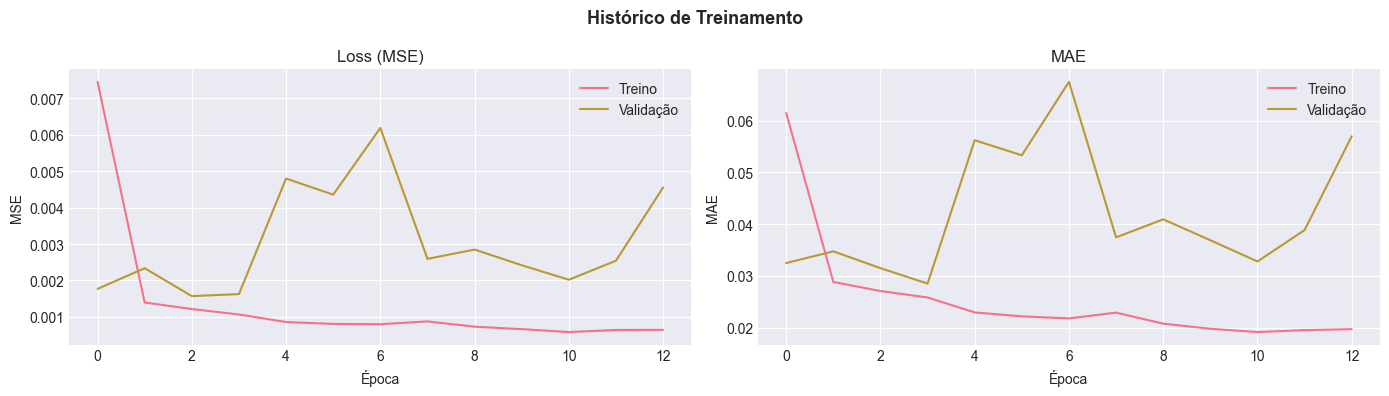

In [19]:
# Curva de Aprendizado
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("Histórico de Treinamento", fontsize=13, fontweight="bold")

axes[0].plot(history.history["loss"],     label="Treino")
axes[0].plot(history.history["val_loss"], label="Validação")
axes[0].set_title("Loss (MSE)")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].plot(history.history["mae"],     label="Treino")
axes[1].plot(history.history["val_mae"], label="Validação")
axes[1].set_title("MAE")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("MAE")
axes[1].legend()

plt.tight_layout()
plt.show()


## 📊 Preço real vs. Preço previsto

Aqui colocamos o modelo à prova de forma visual. A linha azul é o preço real da ação e a linha vermelha é o que o modelo previu. A área laranja entre as duas linhas é o erro — quanto menor essa área, melhor o modelo se saiu.

Se as duas linhas estiverem andando juntas, é sinal de que o modelo aprendeu bem o comportamento da ação.

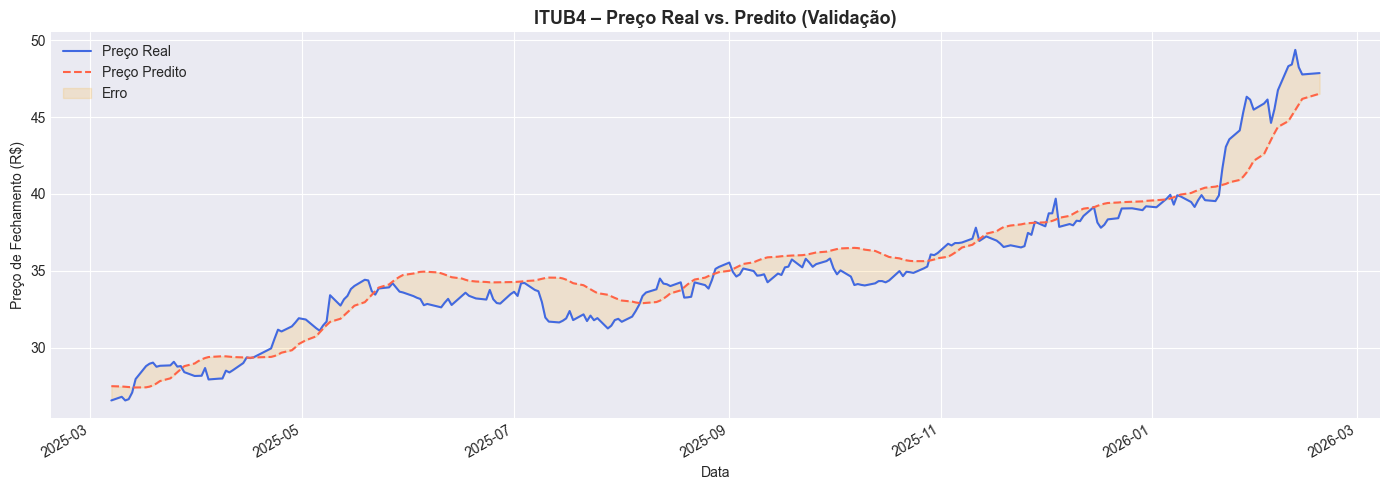

In [20]:
# Predito vs. Real (conjunto de validação)
val_dates = dates.iloc[train_size + SEQ_LENGTH : train_size + SEQ_LENGTH + len(y_val_inv)]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(val_dates, y_val_inv, label="Preço Real",   linewidth=1.5, color="royalblue")
ax.plot(val_dates, y_pred,    label="Preço Predito", linewidth=1.5, color="tomato",  linestyle="--")
ax.fill_between(val_dates,
                y_val_inv.flatten(),
                y_pred.flatten(),
                alpha=0.15, color="orange", label="Erro")
ax.set_title("ITUB4 – Preço Real vs. Predito (Validação)", fontsize=13, fontweight="bold")
ax.set_xlabel("Data")
ax.set_ylabel("Preço de Fechamento (R$)")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## 🔮 Previsão dos próximos 5 dias

Aqui o modelo olha para os últimos 60 dias de preço e tenta prever o que vem a seguir. Ele faz isso um dia de cada vez — prevê o primeiro dia, usa essa previsão para prever o segundo, e assim por diante até completar os 5 dias úteis.

O gráfico mostra o histórico recente em azul e os 5 dias previstos em vermelho. A linha cinza pontilhada marca onde termina o histórico real e começa a previsão.

Vale lembrar que quanto mais o modelo "chuta" para frente, menos confiante ele fica — afinal, ele está usando as próprias previsões como entrada, e qualquer erro vai se acumulando ao longo dos dias.


  Previsão ITUB4 – Próximos 5 dias
  19/02/2026 (seg–sex)  →  R$ 46.83
  20/02/2026 (seg–sex)  →  R$ 47.10
  23/02/2026 (seg–sex)  →  R$ 47.32
  24/02/2026 (seg–sex)  →  R$ 47.50
  25/02/2026 (seg–sex)  →  R$ 47.64


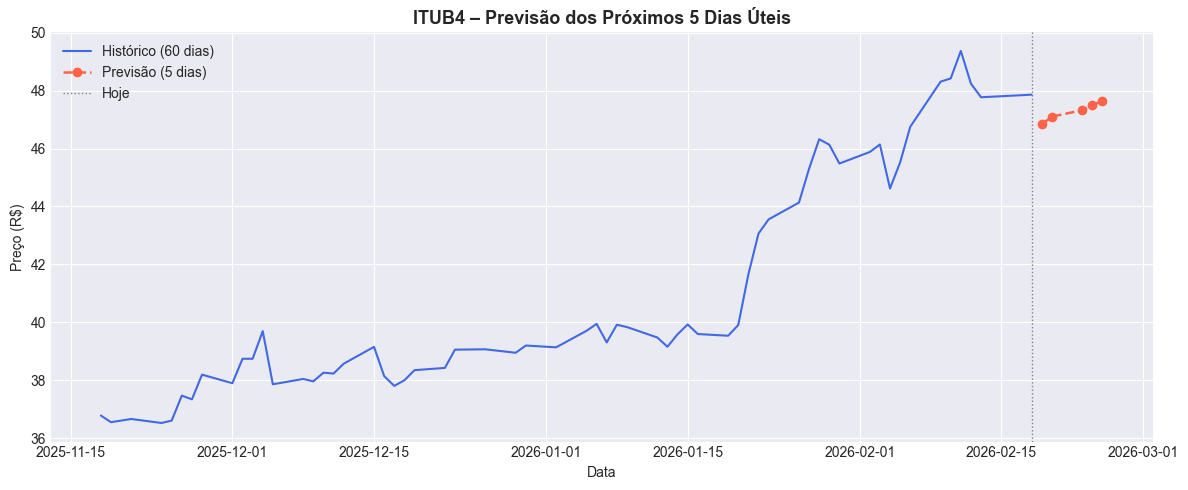

In [21]:
# Previsão dos próximos 5 dias úteis
FORECAST_DAYS = 5
last_seq = scaled_prices[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)

future_scaled = []
current_seq = last_seq.copy()
for _ in range(FORECAST_DAYS):
    pred = model.predict(current_seq, verbose=0)
    future_scaled.append(pred[0, 0])
    current_seq = np.append(current_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

future_prices = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()

# Gerar datas futuras (dias úteis)
last_date = pd.to_datetime(df["date"].iloc[-1])
future_dates = pd.bdate_range(start=last_date + pd.offsets.BDay(1), periods=FORECAST_DAYS)

print("\n" + "=" * 40)
print("  Previsão ITUB4 – Próximos 5 dias")
print("=" * 40)
for d, p in zip(future_dates, future_prices):
    print(f"  {d.strftime('%d/%m/%Y')} (seg–sex)  →  R$ {p:.2f}")
print("=" * 40)

# Plotar contexto + forecast
context_n = 60
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates.iloc[-context_n:], df["close"].iloc[-context_n:],
        label="Histórico (60 dias)", color="royalblue", linewidth=1.5)
ax.plot(future_dates, future_prices,
        label=f"Previsão ({FORECAST_DAYS} dias)", color="tomato",
        linewidth=1.8, linestyle="--", marker="o", markersize=6)
ax.axvline(x=last_date, color="gray", linestyle=":", linewidth=1, label="Hoje")
ax.set_title("ITUB4 – Previsão dos Próximos 5 Dias Úteis", fontsize=13, fontweight="bold")
ax.set_xlabel("Data")
ax.set_ylabel("Preço (R$)")
ax.legend()
plt.tight_layout()
plt.show()